Code is adapted from 
[this code](https://nbviewer.jupyter.org/url/argmin.net/code/little_LQR_demo.ipynb) 
from the [argmin blog post on LQR](http://www.argmin.net/2018/02/08/lqr/)

## LQR
- [Linear–quadratic regulator](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator)
- [Linear–quadratic–Gaussian control](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic%E2%80%93Gaussian_control)
- [(Differential) Riccati equation](https://en.wikipedia.org/wiki/Riccati_equation)
- [Algebraic Riccati equation](https://en.wikipedia.org/wiki/Algebraic_Riccati_equation)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import inv, solve_continuous_are, solve_discrete_are

In [3]:
def lqr(A, B, Q, R, is_discrete=True):
    """Solve for optimal infinite-horizon LQR gain matrix K, given
    linear system x(t+1) = Ax(t) + Bu(t), and
    quadratic cost function g(x,u) = x(t)'Qx(t) + u(t)'Ru(t).
    
    Notes
    -----
    Optimal policy is u* = -Kx.
    System is underactuated if rank(B) < rank(A).

    
    Parameters
    ----------
    A : (M, M) array_like
        Square matrix
    B : (M, N) array_like
        Matrix 
    Q : (M, M) array_like
        Positive semi-definite, symmetic matrix
    R : (N, N) array_like
        Positive definite, symmetic matrix
    """
    if is_discrete:
        # solve discrete algebraic Riccati equation
        S = solve_discrete_are(A, B, Q, R)
        # K = (R + B'SB)^(-1) * (B'SA)
        K = np.dot(inv(R + B.T.dot(S).dot(B)), (B.T.dot(S).dot(A)))
    else:
        # solve continuous algebraic Riccati equation
        S = solve_continuous_are(A, B, Q, R)
        # K = -R^(-1)B'S
        K = -inv(R).dot(B.T).dot(S)
    return K

In [4]:
def simulate_static_gain(A, B, K, x0, time_steps):
    """Simulates the linear system x(t+1) = Ax(t) + Bu(t) 
    with static control law u(t) = -Kx(t)
    
    Parameters
    ----------
    A : (M, M) array_like
    B : (M, N) array_like
    K : (N, M) array_like
        gain matrix
    x0 : (M, 1) array_like
        inital condition of system
    time_steps : int
        number of discrete time steps to simulate
    
    Returns
    -------
    U : (N, T)
        control
    X : (M, T)
        trajectory
    """
    X = x0
    U = np.zeros((len(K), 1))
    for t in range(time_steps-1):
        x_t = X[:, -1]
        u_t = -K.dot(x_t)
        U = np.hstack((U, u_t[:, None]))
        x_tp1 = A.dot(x_t) + B.dot(u_t)
        X = np.hstack((X, x_tp1[:, None]))
    return U, X

In [12]:
def plot_trajectories(x1, x2, ylabel):
    colors = [ '#2D328F', '#F15C19' ]
    label_fontsize = 18
    tick_fontsize = 14
    linewidth = 3

    T = x1.shape[0]
    t = np.arange(0,T)
    plt.plot(t,x1,color=colors[0], linewidth=linewidth, label='low R')
    plt.plot(t,x2,color=colors[1], linewidth=linewidth, label='high R')
        
    plt.xlabel('time', fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    plt.xticks(fontsize=tick_fontsize)
    plt.yticks(fontsize=tick_fontsize)

    plt.grid(True)
    plt.show()
    

In [13]:
# state transition matrices for linear system: 
# x(t+1) = Ax(t) + Bu(t)
A = np.array([[1, 1],
              [0, 1]])
B = np.array([[0],
              [1]])

# LQR quadratic cost per state
Q = np.array([[1,0],
              [0,0]])
R = np.ones((B.shape[1], B.shape[1]))

# initial condition for system
q0 = -1  # initial position
q0_dot = 0  # initial velocity
x0 = np.vstack((q0, q0_dot))

In [19]:
T = 30  # number of time steps to simulate

K_lo = lqr(A, B, Q, R)
U_lo, X_lo = simulate_static_gain(A, B, K_lo, x0, T)

K_hi = lqr(A, B, Q, R*100)
U_hi, X_hi = simulate_static_gain(A, B, K_hi, x0, T)

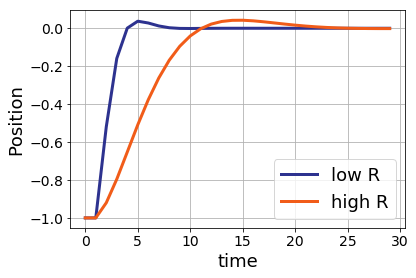

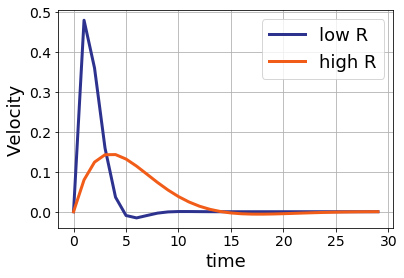

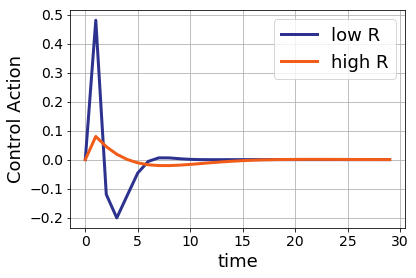

In [20]:
plot_trajectories(X_lo[0,:], X_hi[0,:], 'Position')
plot_trajectories(X_lo[1,:], X_hi[1,:], 'Velocity')
plot_trajectories(U_lo.T, U_hi.T, 'Control Action')